In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

In [83]:
train_df = pd.read_csv("./Data/train_clean.csv")
valid_df = pd.read_csv("./Data/valid_clean.csv")

In [84]:
X_train = train_df.drop(columns=["ID", "Label"])
y_train = train_df["Label"]

X_valid = valid_df.drop(columns=["ID", "Label"])
y_valid = valid_df["Label"]

In [85]:
text_col = "Statement"
cat_cols = ["Party Affiliation", "Speaker Job Title", "State Info"]
num_cols = ["char_count", "word_count", "avg_word_length", "true_ratio", "false_ratio"]

In [86]:
text_transformer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=5,           
    max_df=0.7,         
    stop_words='english'
)

cat_transformer = OneHotEncoder(handle_unknown="ignore")

num_transformer = StandardScaler()


preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_col),
        ("cat", cat_transformer, cat_cols),
        ("num", num_transformer, num_cols)
    ],
    remainder='drop'
)

In [87]:
gradient_boosting_model = Pipeline([
    ("preprocess", preprocessor),
    ("gb", GradientBoostingClassifier(
        n_estimators=100,           # Reduced number of trees
        learning_rate=0.05,         # Lower learning rate
        max_depth=2,                # Shallower trees
        min_samples_split=100,      # More samples required to split
        min_samples_leaf=50,        # More samples per leaf
        subsample=0.6,              # Lower subsampling ratio
        max_features='sqrt',        # Use sqrt of features for each tree
        random_state=42,
        validation_fraction=0.1,    # Use 10% for early stopping
        n_iter_no_change=5,         # Stop if no improvement for 5 iterations
        tol=1e-4                    # Tolerance for early stopping
    ))
])

In [88]:
param_grid = {
    'gb__n_estimators': [80, 100, 120],
    'gb__learning_rate': [0.05, 0.1],
    'gb__max_depth': [2, 3],
    'gb__min_samples_split': [50, 100],
    'gb__min_samples_leaf': [30, 50],
    'gb__subsample': [0.6, 0.7],
    'gb__max_features': ['sqrt', 0.3]
}

grid_search = GridSearchCV(
    gradient_boosting_model, 
    param_grid, 
    cv=5,  
    scoring='f1_macro', 
    n_jobs=-1,
    verbose=1
)

In [89]:
print("Training Gradient Boosting model...")
gradient_boosting_model.fit(X_train, y_train)
print("Training completed!")

Training Gradient Boosting model...
Training completed!


In [90]:
y_train_pred = gradient_boosting_model.predict(X_train)

print("Training Results:")
print(classification_report(y_train, y_train_pred))
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

Training Results:
              precision    recall  f1-score   support

 barely-true       0.49      0.03      0.06      1654
       false       0.35      0.58      0.43      1995
   half-true       0.31      0.63      0.41      2114
 mostly-true       0.48      0.55      0.51      1962
  pants-fire       0.75      0.01      0.01       839
        true       0.60      0.08      0.14      1676

    accuracy                           0.37     10240
   macro avg       0.50      0.31      0.26     10240
weighted avg       0.46      0.37      0.30     10240

Training Accuracy: 0.36650390625


In [91]:
y_valid_pred = gradient_boosting_model.predict(X_valid)

print("Validation Results:")
print(classification_report(y_valid, y_valid_pred))
print("Validation Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Macro F1 Score:", f1_score(y_valid, y_valid_pred, average='macro'))

Validation Results:
              precision    recall  f1-score   support

 barely-true       0.22      0.01      0.02       237
       false       0.32      0.51      0.39       263
   half-true       0.26      0.59      0.37       248
 mostly-true       0.49      0.51      0.50       251
  pants-fire       0.00      0.00      0.00       116
        true       0.38      0.06      0.10       169

    accuracy                           0.33      1284
   macro avg       0.28      0.28      0.23      1284
weighted avg       0.30      0.33      0.27      1284

Validation Accuracy: 0.3294392523364486
Macro F1 Score: 0.2292917651729934


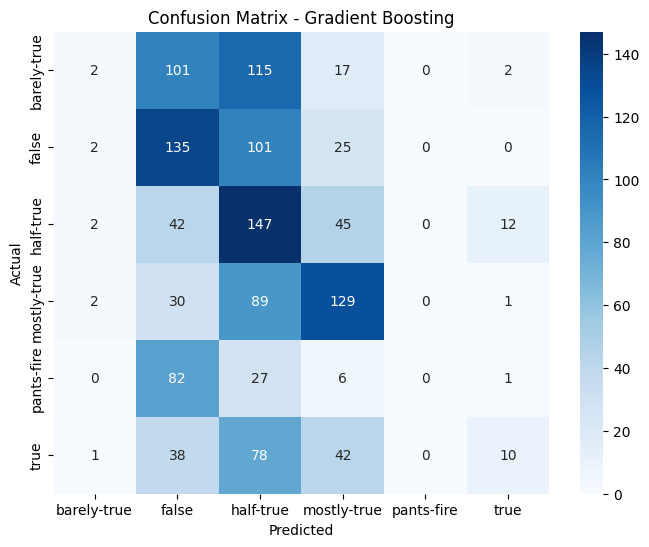

In [92]:
cm = confusion_matrix(y_valid, y_valid_pred, labels=gradient_boosting_model.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=gradient_boosting_model.classes_, yticklabels=gradient_boosting_model.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

In [93]:
print("\n=== MODEL SUMMARY ===")
print("Model: gradient_boosting")
print("Preprocessing: basic")
print("Vectorizer: tfidf_standard")
print("Training Accuracy:", round(accuracy_score(y_train, y_train_pred), 4))
print("Validation Accuracy:", round(accuracy_score(y_valid, y_valid_pred), 4))
print("F1 Macro Score:", round(f1_score(y_valid, y_valid_pred, average='macro'), 4))


=== MODEL SUMMARY ===
Model: gradient_boosting
Preprocessing: basic
Vectorizer: tfidf_standard
Training Accuracy: 0.3665
Validation Accuracy: 0.3294
F1 Macro Score: 0.2293
